# Timing of melt lake detections

In [13]:
%matplotlib widget
import os
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import h5py
import math
import datetime
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image, display
from matplotlib.collections import PatchCollection
from sklearn.neighbors import KDTree
from scipy.stats import binned_statistic
from scipy.signal import find_peaks

In [14]:
out_path_csv = '/Volumes/nox/Philipp/IceLakesRun2/GlacierLakeDetectionICESat2/GLD2_lakestats_for-wais_ross-fix_gooddata.csv'
df = pd.read_csv(out_path_csv)

In [15]:
df_lakes = df[((df.quality_summary > 0) 
               & (df.surface_elevation > 1.0) 
               & (df.max_depth < 50) 
               & (df.max_depth > 0.5))].copy()
df_lakes.sort_values(by='quality_summary', ascending=False, inplace=True)
len(df_lakes)

df_lakes_hq = df_lakes.copy()
# df_lakes[df_lakes.quality_summary > 0.01]
len(df_lakes_hq)

6044

In [16]:
sz_sup = 14
sz_tit_l = 12
sz_tit_s = 7
sz_lab_l = 10
sz_lab_s = 6
sz_tck_l = 8
sz_tck_s = 5
colors = {'GrIS': '#D00C33', # Greenland flag
          'AIS': '#3A7DCE' # Antarctica, Graham Bartram Design
         }

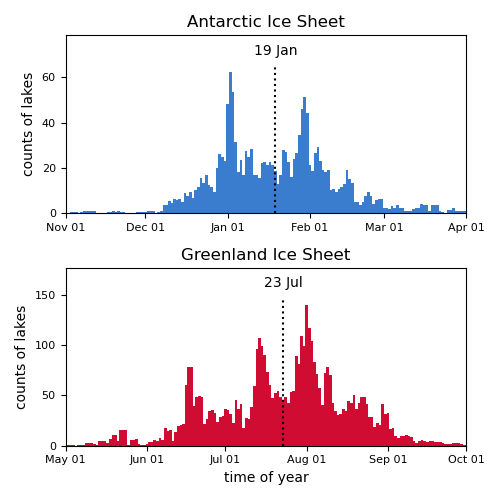

In [91]:
import calendar
def get_doy(x):
    doy = x.dtime.timetuple().tm_yday
    if calendar.isleap(x.dtime.year):
        if doy==60:
            doy = -1
        if doy>60:
            doy -= 1
    return doy
    
fig, axs = plt.subplots(figsize=[5,5], nrows=2)
for i,sheet in enumerate(['AIS', 'GrIS']):
    dfi = df_lakes_hq[df_lakes_hq.ice_sheet == sheet]
    dfdt = dfi[['ice_sheet', 'basin', 'date_time', 'quality_summary']].copy()
    dfdt['dtime'] = dfdt.apply(lambda x: datetime.datetime.strptime(x.date_time,'%Y-%m-%dT%H:%M:%SZ'), axis=1)
    dfdt['doy'] = dfdt.apply(get_doy, axis=1)
    cnts = dfdt.groupby('doy')['dtime'].count()
    if -1 in cnts.index:
        cnts = cnts.drop([-1]) # drop feb 29 values
    dayhist = pd.DataFrame({'doy': np.array(cnts.index), 'cnts': np.array(cnts)})
    days = np.arange(1,366)
    counts = np.zeros_like(days)
    counts[cnts.index-1] = cnts
    dayhist = pd.DataFrame({'doy': days, 'cnts': counts})
    dayhist.loc[dayhist.doy>300,'doy'] -= 365
    ax = axs[i]
    dayhist.sort_values(by='doy', inplace=True)
    dayhist['cnt_smooth'] = dayhist.cnts.rolling(window=3, center=True, min_periods=0).mean()
    meanday = np.round(np.average(dayhist.doy, weights=dayhist.cnts))
    meandoy = meanday+365 if meanday<0 else meanday
    mean_date = (datetime.date(2019,1,1) + datetime.timedelta(days=int(meandoy) - 1)).strftime("%d %b")
    
    ax.bar(dayhist.doy, dayhist.cnt_smooth, 1, color=colors[sheet])
    # ax.bar(dayhist.doy, dayhist.cnts, 0.3, color='k')
    months = [5, 6, 7, 8, 9, 10] if sheet == 'GrIS' else [11, 12, 1, 2, 3, 4]
    tckdtms = [datetime.datetime(2019,m,1) for m in months]
    tckdoys = [d.timetuple().tm_yday for d in tckdtms]
    tckdoys = [d-365 if d>300 else d for d in tckdoys]
    tckstrs = [datetime.datetime.strftime(d, '%b %d') for d in tckdtms]
    ax.set_xticks(tckdoys)
    ax.set_xticklabels(tckstrs)

    yl = ax.get_ylim()
    ax.plot([meanday]*2, yl, 'k:', zorder=1000)
    ax.text(meanday,yl[1]*1.05,'%s'%mean_date,ha='center',va='bottom')

    sheet_name = 'Antarctic Ice Sheet' if sheet=='AIS' else 'Greenland Ice Sheet'
    ax.set_title(sheet_name, fontsize=sz_tit_l)
    ax.set_ylabel('counts of lakes', fontsize=sz_lab_l)
    if i==1:
        ax.set_xlabel('time of year', fontsize=sz_lab_l)
    ax.set_xlim((tckdoys[0], tckdoys[-1]))
    ax.set_ylim(np.array(yl)*1.2)
    ax.tick_params(axis='both', labelsize=sz_tck_l)

fig.tight_layout()
fig.savefig('plots/timing_all_data.jpg', dpi=600)

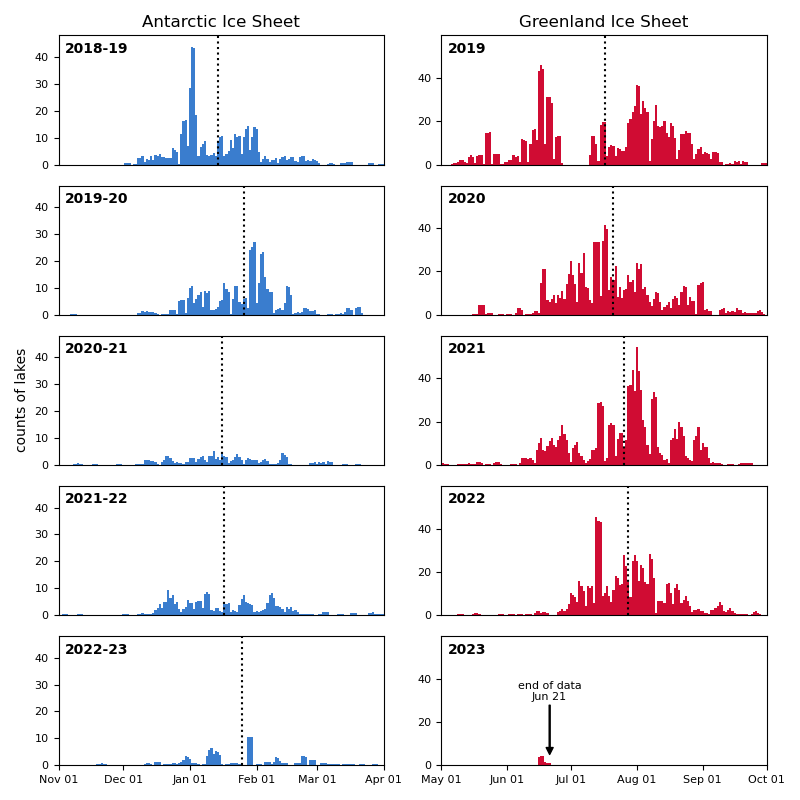

In [89]:
fig, axs = plt.subplots(figsize=[8,8], ncols=2, nrows=5)
maxant = 0
maxgre = 0
for i,sheet in enumerate(['AIS', 'GrIS']):
    for j,year in enumerate(np.arange(2018,2023)):
        melt_season = '%i-%i'%(year,year+1-2000) if sheet=='AIS' else '%i'%(year+1)
        dfi = df_lakes_hq[(df_lakes_hq.ice_sheet == sheet) & (df_lakes_hq.melt_season == melt_season)]
        dfdt = dfi[['ice_sheet', 'basin', 'date_time', 'quality_summary']].copy()
        dfdt['dtime'] = dfdt.apply(lambda x: datetime.datetime.strptime(x.date_time,'%Y-%m-%dT%H:%M:%SZ'), axis=1)
        dfdt['doy'] = dfdt.apply(get_doy, axis=1)
        cnts = dfdt.groupby('doy')['dtime'].count()
        if -1 in cnts.index:
            cnts = cnts.drop([-1]) # drop feb 29 values
        dayhist = pd.DataFrame({'doy': np.array(cnts.index), 'cnts': np.array(cnts)})
        days = np.arange(1,366)
        counts = np.zeros_like(days)
        counts[cnts.index-1] = cnts
        dayhist = pd.DataFrame({'doy': days, 'cnts': counts})
        dayhist.loc[dayhist.doy>300,'doy'] -= 365
        ax = axs[j,i]
        dayhist.sort_values(by='doy', inplace=True)
        dayhist['cnt_smooth'] = dayhist.cnts.rolling(window=3, center=True,min_periods=0).mean()
        meanday = np.round(np.average(dayhist.doy, weights=dayhist.cnts))
        meandoy = meanday+365 if meanday<0 else meanday
        mean_date = (datetime.date(2019,1,1) + datetime.timedelta(days=int(meandoy) - 1)).strftime("%d %b")
        
        ax.bar(dayhist.doy, dayhist.cnt_smooth, 1, color=colors[sheet])
        # ax.bar(dayhist.doy, dayhist.cnts, 0.3, color='k')
        months = [5, 6, 7, 8, 9, 10] if sheet == 'GrIS' else [11, 12, 1, 2, 3, 4]
        tckdtms = [datetime.datetime(2019,m,1) for m in months]
        tckdoys = [d.timetuple().tm_yday for d in tckdtms]
        tckdoys = [d-365 if d>300 else d for d in tckdoys]
        tckstrs = [datetime.datetime.strftime(d, '%b %d') for d in tckdtms]
        if j==4:
            ax.set_xticks(tckdoys)
            ax.set_xticklabels(tckstrs)
        else:
            ax.set_xticks([])

        if (i<1) or (j<4):
            ax.plot([meanday]*2, [0, 5000], 'k:', zorder=1000)
        # ax.text(meanday,yl[1],'%s\n'%mean_date,ha='center',va='bottom')
    
        sheet_name = 'Antarctic Ice Sheet' if sheet=='AIS' else 'Greenland Ice Sheet'
        ax.text(0.02,0.95, melt_season, transform=ax.transAxes, ha='left', va='top', fontweight='bold')
        if (i==0) & (j==2):
            ax.set_ylabel('counts of lakes', fontsize=sz_lab_l)
        ax.set_xlim((tckdoys[0], tckdoys[-1]))
        ax.set_ylim(np.array(yl)*1.2)
        ax.tick_params(axis='both', labelsize=sz_tck_l)

        if sheet == 'AIS':
            maxant = np.max((maxant, dayhist.cnt_smooth.max()))
        else:
            maxgre = np.max((maxgre, dayhist.cnt_smooth.max()))

        if j==0:
            ax.set_title(sheet_name)

        if (i==1) and (j==4):
            ax.annotate('end of data\nJun 21', xy=[172,5], xytext=[172,30], zorder=1000, ha='center', fontsize=8,
                        arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='k'))

for j in range(5):
    axs[j,0].set_ylim((0,maxant*1.1))
    axs[j,1].set_ylim((0,maxgre*1.1))
    
fig.tight_layout()
fig.savefig('plots/timing_by_melt_season.jpg', dpi=600)

In [58]:
cnts

doy
1       5
2      78
3      48
4       4
5       3
       ..
359    13
360     1
363    34
364    14
365     2
Name: dtime, Length: 75, dtype: int64